In [1]:
from pprint import pprint
from pandas_datareader.famafrench import get_available_datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS, add_constant
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
from pathlib import Path
from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel, LinearFactorModelGMM

In [2]:
plt.style.use('fivethirtyeight')

In [85]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2017-12')[0]
ff_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 6 columns):
Mkt-RF    96 non-null float64
SMB       96 non-null float64
HML       96 non-null float64
RMW       96 non-null float64
CMA       96 non-null float64
RF        96 non-null float64
dtypes: float64(6)
memory usage: 5.2 KB


In [4]:
with pd.HDFStore('../../data/assets.h5') as store:
    prices = store['/quandl/wiki/prices'].adj_close.unstack().loc['2010':'2017']
    equities = store['/us_equities/stocks'].drop_duplicates()

In [5]:
sectors = equities.filter(prices.columns, axis=0).sector.to_dict()
prices = prices.filter(sectors.keys()).dropna(how='all', axis=1)

In [6]:
returns = prices.resample('M').last().pct_change().mul(100).to_period('M')
returns = returns.dropna(how='all').dropna(axis=1)
returns.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Columns: 1936 entries, A to ZUMZ
dtypes: float64(1936)
memory usage: 1.4 MB


#### Align data

In [7]:
ff_data = ff_data.loc[returns.index]

In [8]:
ff_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,1.206000,0.055158,-0.069158,0.143789,0.045158,0.012737
std,3.568367,2.307945,2.205636,1.546619,1.416252,0.022665
min,-7.890000,-4.570000,-4.500000,-3.710000,-3.320000,0.000000
25%,-0.565000,-1.605000,-1.520000,-0.940000,-0.995000,0.000000
50%,1.290000,0.130000,-0.280000,0.300000,-0.010000,0.000000
75%,3.260000,1.550000,1.140000,1.150000,0.925000,0.010000
max,11.350000,6.810000,8.270000,3.610000,3.670000,0.090000


#### Compute excess Returns

In [83]:
excess_returns = returns.sub(ff_data.RF, axis=0)
excess_returns.info()

ValueError: can only call with other PeriodIndex-ed objects

In [10]:
excess_returns = excess_returns.clip(lower=np.percentile(excess_returns, 1),
                                     upper=np.percentile(excess_returns, 99))

### Fama-Macbeth Regression

#### Select Factor Data

In [50]:
factors = ff_data.drop('RF', axis=1)
demeaned_factors = factors.sub(factors.mean())

In [47]:
excess_returns = excess_returns.iloc[:, :90]

#### Step 1: Asset Exposure

In [76]:
betas = []
for asset in excess_returns.dropna(axis=1):
    step1 = OLS(endog=excess_returns[asset], 
                exog=add_constant(demeaned_factors)).fit()
    betas.append(step1.params.drop('const'))

In [77]:
betas = pd.DataFrame(betas, 
                     columns=factors.columns, 
                     index=excess_returns.columns)
betas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, A to AME
Data columns (total 5 columns):
Mkt-RF    90 non-null float64
SMB       90 non-null float64
HML       90 non-null float64
RMW       90 non-null float64
CMA       90 non-null float64
dtypes: float64(5)
memory usage: 6.7+ KB


#### Step 2: Risk Premia

In [78]:
lambdas = []
for period in returns.index:
    step2 = OLS(endog=excess_returns.loc[period, betas.index], 
                exog=betas).fit()
    lambdas.append(step2.params)

In [79]:
lambdas = pd.DataFrame(lambdas, 
                       index=excess_returns.index,
                       columns=betas.columns.tolist())
lambdas.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 95 entries, 2010-02 to 2017-12
Freq: M
Data columns (total 5 columns):
Mkt-RF    95 non-null float64
SMB       95 non-null float64
HML       95 non-null float64
RMW       95 non-null float64
CMA       95 non-null float64
dtypes: float64(5)
memory usage: 7.0 KB


In [80]:
lambdas.mean()

Mkt-RF    1.161380
SMB       0.457831
HML      -0.684284
RMW      -0.014659
CMA      -0.122546
dtype: float64

In [82]:
t = lambdas.mean().div(lambdas.std())
t

Mkt-RF    0.314570
SMB       0.171180
HML      -0.243295
RMW      -0.006962
CMA      -0.065443
dtype: float64

#### Results

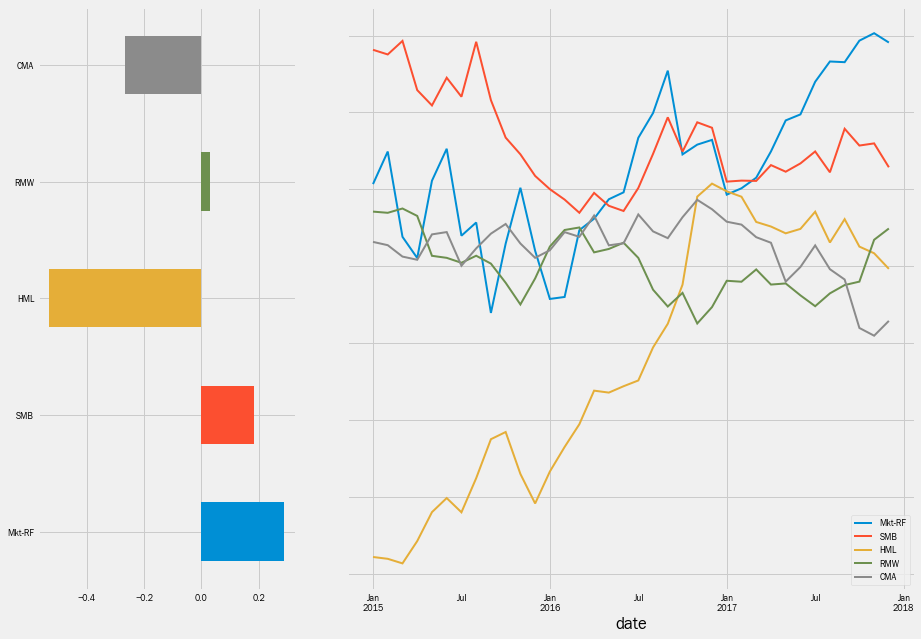

In [41]:
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().plot.barh(ax=ax1)
lambdas.rolling(60).mean().plot(lw=2, figsize=(14,10), sharey=True, ax=ax2);

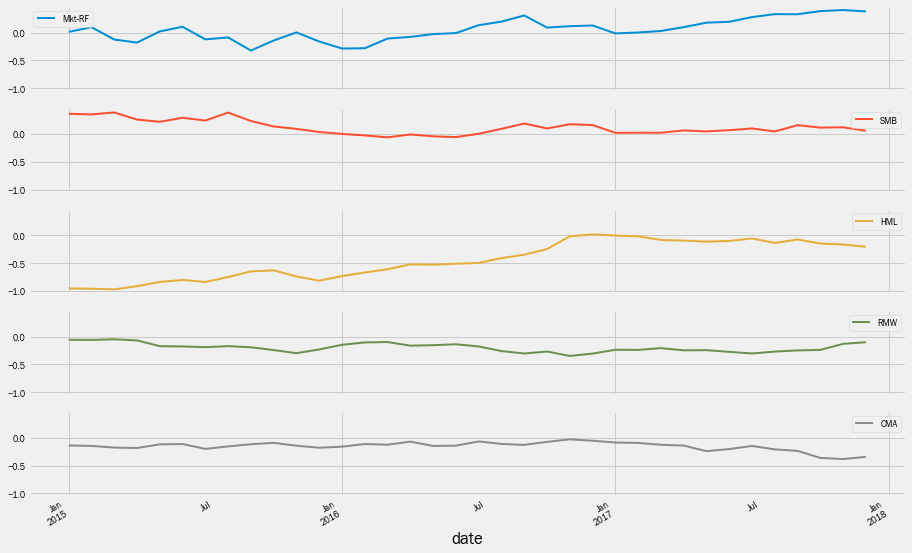

In [55]:
lambdas.rolling(60).mean().plot(lw=2, figsize=(14,10), subplots=True,sharey=True);

In [74]:
lambdas.mean()

const     1.213079
Mkt-RF    0.288028
SMB       0.184663
HML      -0.530586
RMW       0.030517
CMA      -0.265473
dtype: float64

In [66]:
mod = LinearFactorModel(portfolios=excess_returns, 
                        factors=factors)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 90   R-squared:                      0.3186
No. Factors:                          5   J-statistic:                 1.981e+04
No. Observations:                    95   P-value                         0.0000
Date:                  Mon, Sep 03 2018   Distribution:                 chi2(85)
Time:                          09:18:10                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.1614     0.3776     3.0753     0.0021      0.4212      1.9015
SMB            0.4578     0.3201    

In [46]:
lambdas.mean()

Mkt-RF    0.288028
SMB       0.184663
HML      -0.530586
RMW       0.030517
CMA      -0.265473
dtype: float64

In [68]:
mod = LinearFactorModel(portfolios=excess_returns, 
                        factors=factors,
                       risk_free=True)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 90   R-squared:                      0.3186
No. Factors:                          5   J-statistic:                    6684.8
No. Observations:                    95   P-value                         0.0000
Date:                  Mon, Sep 03 2018   Distribution:                 chi2(84)
Time:                          09:26:07                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
risk_free      1.2131     0.3623     3.3482     0.0008      0.5030      1.9232
Mkt-RF         0.2880     0.4521    